# 1. Problem Statement and Background

- Dingyi Zhou: zhou.ding@northeastern.edu

Student mental health is a critical concern in educational environments, with rising rates of depression among students posing a significant challenge to overall campus well-being and academic success. This project investigates the research question: **Which factors most significantly influence student depression?** Addressing this question is crucial because mental health issues among students are not only prevalent but also have far-reaching consequences, such as diminished quality of life, lower academic achievement, and higher dropout rates. Recent surveys indicate that the rate of depression in college populations is steadily rising in the U.S., and similar trends are observed internationally. Such mental health challenges undermine students’ ability to perform academically and can lead to a cycle of adverse outcomes, affecting their career prospects and personal lives.
https://www.mayoclinichealthsystem.org/hometown-health/speaking-of-health/college-students-and-depression#:~:text=The%20rate%20of%20depression%20among,suicide%20in%20the%20past%20year

https://research.com/education/student-stress-statistics#:~:text=death.%20,more%20likely%20to%20attend%20college

A major driver of student mental health problems is the increasing stress inherent in modern academic environments. Students today face intense pressure to excel academically while simultaneously managing heavy course loads, financial burdens, and personal challenges. This multi-dimensional stress – ranging from the need to maintain top grades, compete for limited resources, and secure funding for tuition, to balancing part-time jobs and family responsibilities – contributes significantly to chronic stress and anxiety. Studies confirm that excessive academic stress is directly associated with higher depression levels among students, as the constant demand to perform can lead to feelings of burnout and hopelessness. This chronic stress has far-reaching effects, negatively impacting academic performance and overall well-being by inducing symptoms such as anxiety, irritability, and in severe cases, clinical depression.

In this context, understanding which specific stressors or aspects of student life contribute most to depression is paramount for developing effective interventions. By identifying key factors – such as academic pressure, financial stress, and satisfaction with studies – educators and policymakers can design targeted mental health support and resource allocation initiatives. Such efforts could include enhanced academic advising, improved financial aid packages, and the creation of supportive learning environments that prioritize student satisfaction and well-being. Ultimately, a nuanced understanding of these influences can help institutions implement proactive measures to mitigate the adverse effects of these stressors, thereby fostering a healthier, more resilient student population.

# 2. Introduction and Description of Data

Data Set: 
https://www.kaggle.com/datasets/adilshamim8/student-depression-dataset

For this analysis, we chose the Student Depression Dataset from Kaggle because it provides a compilation of student lifestyle and stress factors alongside a measure of depression. According to the dataset description, it compiles information on various potential contributors to student depression, offering a valuable resource to investigate our research question. This dataset focuses on college-age students and includes survey responses on multiple dimensions of academic life and personal well-being. While the data’s geographic context may introduce some bias in generalization, the core factors measured are common stressors for students worldwide.

Key dataset characteristics: The data contains around 140,000 student records with features capturing academic, personal, and mental health variables. Each student entry includes indicators such as gender, age, academic performance (CGPA), and hours of study, among others. For our analysis, we focused on four main features most relevant to the research question: **Academic Pressure, Financial Stress, Study Satisfaction, and Depression.** These were selected as they directly relate to academic and financial strain and personal contentment with studies – factors hypothesized to influence mental health. The first three are self-reported on a Likert scale (values 1 through 5, with higher values indicating greater pressure/stress or satisfaction), and the last is a binary outcome indicating whether the student is suffering from depression (1 for “yes, depressed” and 0 for “no, not depressed”). By concentrating on these features, we aim to quantify how academic and financial strains versus positive academic experiences (satisfaction) correlate with the likelihood of depression in students.

The target variable, Depression, is presumably derived from the survey. The predictor variables are defined as follows: Academic Pressure reflects the level of academic stress or workload pressure a student feels; Financial Stress indicates the strain from financial issues or concerns (such as tuition costs or personal finances); and Study Satisfaction measures how satisfied or content the student is with their studies (which could encompass satisfaction with academic program, learning experience, etc.). Focusing on these allows us to examine both negative factors (pressure, stress) and a positive factor (satisfaction) in relation to student depression.

# 3. Method
Our analysis focused on investigating the relationships between three key factors—Academic Pressure, Financial Stress, and Study Satisfaction—and the binary outcome of student depression. To ensure reproducibility and clarity, we structured our approach into several modular components: data cleaning, model fitting, and visualization. The following steps summarize our methodology:

Before all that happens, we'll import the packages first.

In [4]:
#import the various packages necessary to complete analyses (organizing data, visualizations, linear regressions)
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm


#### Data Cleaning and Preparation

We began by loading the Student Depression Dataset, which includes various self-reported measures from students. For our analysis, we selected the variables of interest:

- Academic Pressure (Likert scale 1–5)

- Financial Stress (Likert scale 1–5)

- Study Satisfaction (Likert scale 1–5)

- Depression (binary outcome: 0 = No, 1 = Yes)

A custom function, clean_data(), was implemented to ensure robust preprocessing. This function filtered the data to retain only the specified predictor and Depression columns, converted these columns to numeric types, and removed any rows with missing values. Additionally, we filtered the data so that the predictor values only spanned the intended range (1 to 5). This ensured that our analysis was based on a consistent and clean subset of the dataset.

In [28]:
def clean_data(df, predictor):
    """
    Cleans the data for the given predictor and the 'Depression' outcome.
    
    Parameters:
      df (pd.DataFrame): The raw input dataframe.
      predictor (str): The name of the predictor column (should be on a 1–5 scale).
      
    Returns:
      pd.DataFrame: A cleaned dataframe with predictor and Depression columns,
                    with values filtered to the range [1, 5].
    """
    # Select only the relevant columns and drop missing values.
    df_clean = df[[predictor, 'Depression']].dropna().copy()
    
    # Convert columns to numeric (in case they were interpreted as strings).
    df_clean[predictor] = pd.to_numeric(df_clean[predictor], errors='coerce')
    df_clean['Depression'] = pd.to_numeric(df_clean['Depression'], errors='coerce')

    # Filter so the predictor is in the 1 to 5 range.
    df_clean = df_clean[(df_clean[predictor] >= 1) & (df_clean[predictor] <= 5)]
    return df_clean


#### Function: load_data **AND** calculate_depression_rate() 

This function computes the depression rate for each level (1–5) of a given categorical factor. It returns three lists: total students per level, depressed students per level, and depression rate per level (as a percentage). This helped us compare patterns across different factors using the same framework.

In [36]:

# download the data before plotting
def load_data(filename):
    with open(filename, "r") as infile:
        lines = infile.readlines()
    header = lines[0].strip().split(",")
    data = [line.strip().split(",") for line in lines[1:]]
    return header, data

header, data = load_data("student_depression_dataset.csv")
## We defined a custom function to load the dataset directly from a .csv file using basic file I/O. The function returns two objects: a header list containing column names and a data list of student records. We avoided using pandas as required.


# define the first function to calculate the total number, number and percentage of people suffering from depression for each level
def calculate_depression_rate(data, header, factor_name, depression_col="Depression"):
    factor_idx = header.index(factor_name)
    depress_idx = header.index(depression_col)
    total = [0] * 5
    depressed = [0] * 5

    for row in data:
        try:
            level = int(float(row[factor_idx]))
            depress = int(row[depress_idx])
            if 1 <= level <= 5:
                total[level - 1] += 1
                if depress == 1:
                    depressed[level - 1] += 1
        except:
            continue

    rate = [(depressed[i] / total[i]) * 100 if total[i] > 0 else 0 for i in range(5)]
    return total, depressed, rate
## This function calculates the total number of students, the number of depressed students, and the depression rate (in percentage) for each level (1–5) of a given categorical factor (e.g., Academic Pressure or Study Satisfaction). These results are used to compare mental health outcomes across different levels of stress or satisfaction.



#### Function: draw_pie_chart()

This function displays the overall proportion of depressed vs. non-depressed students using a pie chart. It was useful to provide an overview of how common depression is in our sample.


In [46]:

# define the second function to plot pie chart
def draw_pie_chart(data, header, target="Depression"):
    idx = header.index(target)
    yes = 0
    no = 0
    for row in data:
        try:
            if int(row[idx]) == 1:
                yes += 1
            else:
                no += 1
        except:
            continue

    plt.figure(figsize=(6,6))
    plt.pie([no, yes], labels=["Not Depressed", "Depressed"],
            autopct="%.1f%%", colors=["lightgreen", "tomato"], startangle=90)
    plt.title("Depression Distribution Among Students")
    plt.tight_layout()
    plt.show()
## This function draws a pie chart showing the overall proportion of depressed vs. non-depressed students in the dataset. It provides a clear overview of how common depression is among the population.


#### Function: get_distribution()

This function calculates how many students fall into each level of a given factor. We used it to visualize the distribution of responses for variables like Academic Pressure.


In [49]:

# define the third function to statistics on the distribution of a variable
def get_distribution(data, header, factor_name):
    idx = header.index(factor_name)
    counts = [0] * 5
    for row in data:
        try:
            level = int(float(row[idx]))
            if 1 <= level <= 5:
                counts[level - 1] += 1
        except:
            continue
    return counts
## We use this function to compute how many students fall into each of the five levels for a given variable (e.g., academic pressure). This helps us visualize how students are distributed across different stress or satisfaction levels.



#### Function: draw_category_distribution()

This function creates a bar chart showing the number of students at each level of a categorical variable, with percentage labels. This helped us understand the population size and composition of each group.


In [53]:

# define the fourth function to plot bar chart
def draw_category_distribution(counts, title, xlabel):
    total = sum(counts)
    labels = ["1", "2", "3", "4", "5"]
    percents = [round(c / total * 100, 1) for c in counts]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, counts, color="cornflowerblue", edgecolor="black")
    for i in range(5):
        label = f"{counts[i]} people\n{percents[i]}%"
        plt.text(i, counts[i] + 100, label, ha="center", fontsize=10)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Number of Students")
    plt.tight_layout()
    plt.show()
## This function generates a bar chart showing the number and percentage of students in each level of a given factor. The labels above each bar make the distribution more interpretable, which is useful for understanding the overall data structure.


#### Function: draw_bar_with_trend()
This visualization function takes in the output of calculate_depression_rate() and draws a bar chart of depression rates by level, with a red trendline overlay. This helped us detect increasing or decreasing relationships between the factor and depression.


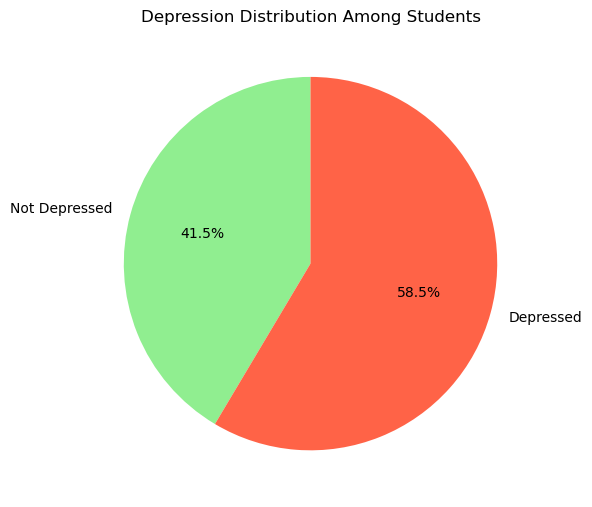

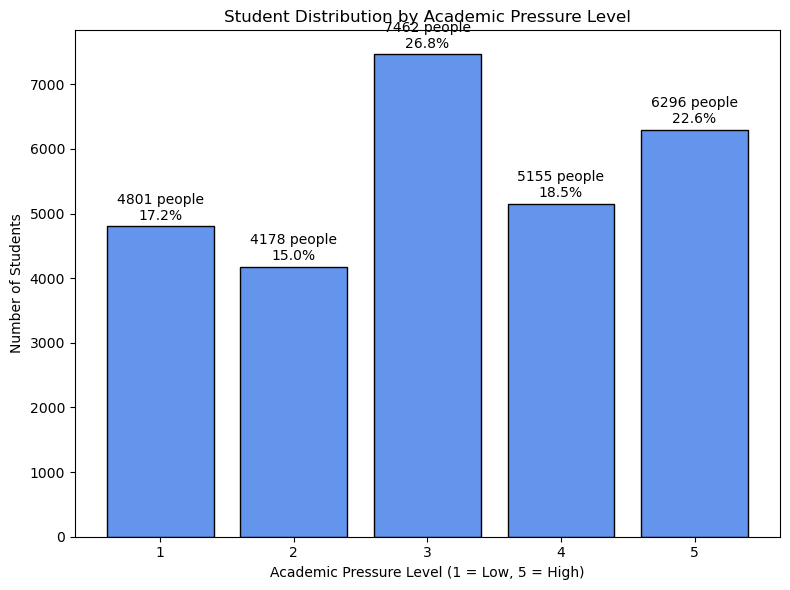

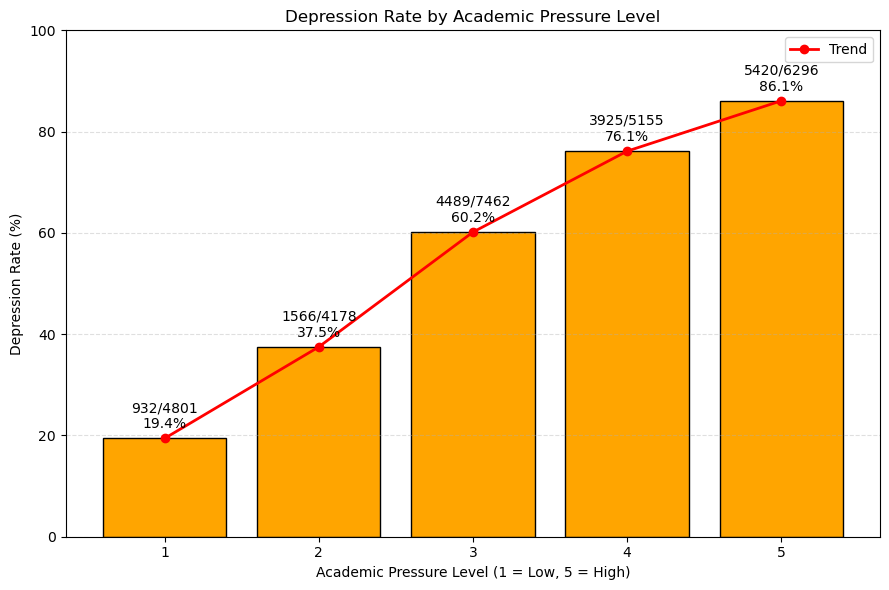

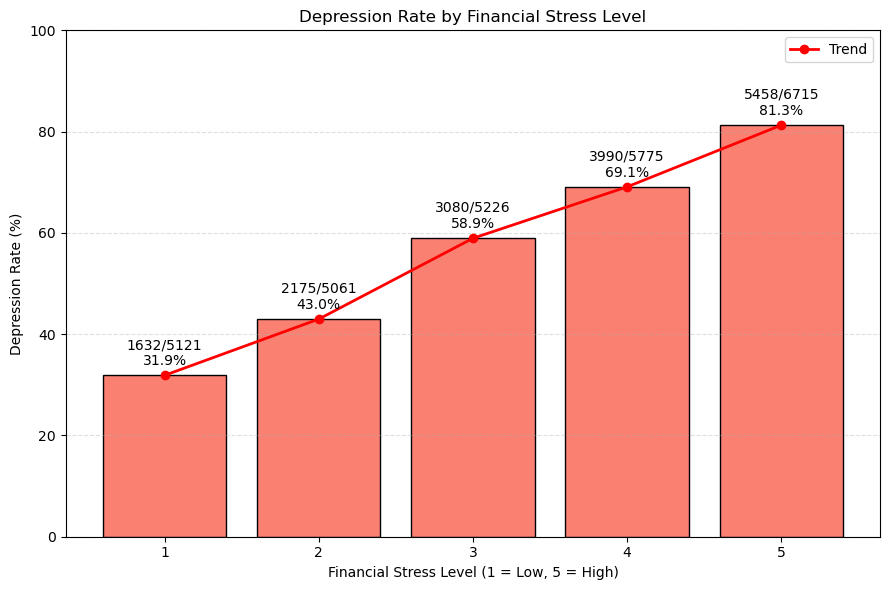

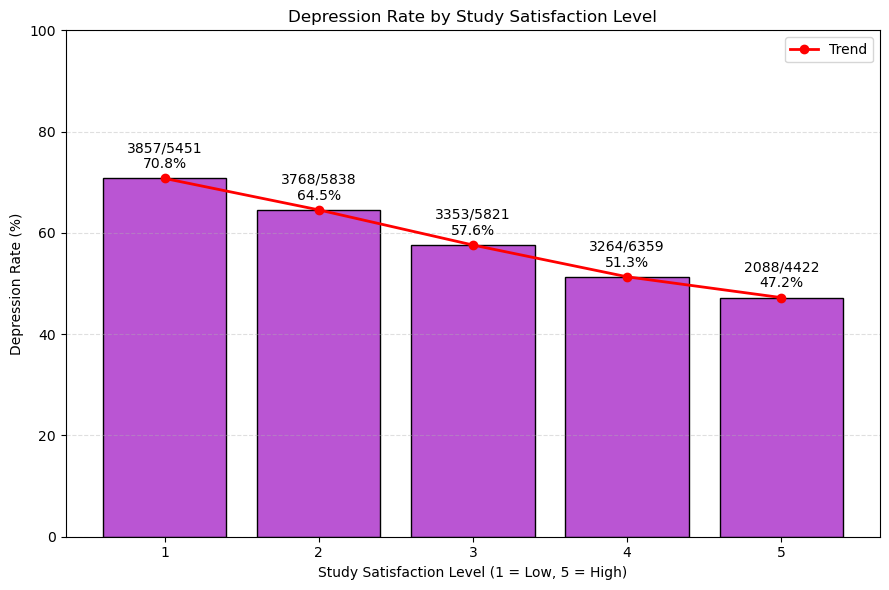

In [62]:

# Define the fifth function to plot a histogram of Depression Rates and Trendline
def draw_bar_with_trend_custom_color(labels, total, depressed, rate, title, xlabel, color):
    plt.figure(figsize=(9, 6))
    plt.bar(labels, rate, color=color, edgecolor='black')
    plt.plot(labels, rate, marker='o', color='red', linewidth=2, label='Trend')
    for i in range(5):
        text = f"{depressed[i]}/{total[i]}\n{round(rate[i],1)}%"
        plt.text(i, rate[i] + 2, text, ha="center", fontsize=10)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Depression Rate (%)")
    plt.ylim(0, 100)
    plt.grid(True, axis='y', linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()
## This function plots a bar chart of depression rates by factor level (1–5) and overlays a red trendline. 

# Call all the functions above
labels = ["1", "2", "3", "4", "5"]

# Graph1 ：Depression overall distribution pie chart
draw_pie_chart(data, header)
## This call visualizes the overall depression distribution in the dataset using a simple two-color pie chart.

# Graph 2：Academic Pressure distribution bar chart
ap_counts = get_distribution(data, header, "Academic Pressure")
draw_category_distribution(ap_counts, "Student Distribution by Academic Pressure Level", "Academic Pressure Level (1 = Low, 5 = High)")
## These lines compute and visualize how students are distributed across the five levels of academic pressure. This helps establish whether certain levels are more common and may thus influence depression rates.

# Graph 3：Depression Rate by Academic Pressure
ap_total, ap_depress, ap_rate = calculate_depression_rate(data, header, "Academic Pressure")
draw_bar_with_trend_custom_color(labels, ap_total, ap_depress, ap_rate, "Depression Rate by Academic Pressure Level", "Academic Pressure Level (1 = Low, 5 = High)", color='orange')
## Here we compute the depression rate by academic pressure level and visualize the result using a bar chart with trendline. This helps us understand how academic stress correlates with depression likelihood.

# Graph 4：Depression Rate by Financial Stress
fs_total, fs_depress, fs_rate = calculate_depression_rate(data, header, "Financial Stress")
draw_bar_with_trend_custom_color(labels, fs_total, fs_depress, fs_rate,"Depression Rate by Financial Stress Level", "Financial Stress Level (1 = Low, 5 = High)", color='salmon')
## This block explores the relationship between financial stress and depression. The salmon color is used for visual consistency with financial themes, and the chart clearly shows whether higher financial stress leads to higher depression risk.

# Graph 5：Depression Rate by Study Satisfaction
ss_total, ss_depress, ss_rate = calculate_depression_rate(data, header, "Study Satisfaction")
draw_bar_with_trend_custom_color(labels, ss_total, ss_depress, ss_rate, "Depression Rate by Study Satisfaction Level", "Study Satisfaction Level (1 = Low, 5 = High)", color='mediumorchid')
## This chart focuses on study satisfaction and its potential protective effect against depression. A decreasing trend would suggest that higher satisfaction is associated with lower depression risk.


By using these functions, we were able to streamline our analysis process and reuse consistent logic across different variables. All charts were created using the matplotlib library to meet the course requirements and avoid any use of external packages.


#### Model Fitting via Logistic Regression:

Given that Depression is a binary outcome, we employed logistic regression to model the relationship between each predictor and the probability of depression. We developed a dedicated function, logistic_regression(), which takes the cleaned data for each predictor, adds a constant term to serve as an intercept, and fits a logistic regression model using statsmodels. The model fit provides McFadden’s pseudo R² value, a measure analogous to R² in linear regression that quantifies the proportion of variance explained by the predictor. This pseudo R² metric enabled us to compare the strength of each factor in influencing depression.

In [65]:
def logistic_regression(df_clean, predictor):
    """
    Fits a logistic regression model using the predictor to predict Depression.
    
    Parameters:
      df_clean (pd.DataFrame): The cleaned data with the specified predictor.
      predictor (str): The column name for the predictor.
    
    Returns:
      result: The fitted statsmodels Logit result object.
    """
    # Set up the predictors (include an intercept).
    X = df_clean[[predictor]]
    X = sm.add_constant(X)
    y = df_clean['Depression']
    
    # Fit logistic regression.
    model = sm.Logit(y, X)
    result = model.fit(disp=False)  # disp=False suppresses output during fitting.
    return result


#### Visualization with Logistic Regression Plots:

We used Seaborn’s regplot with the parameter logistic=True to create scatter plots for each factor vs. Depression. A separate function, plot_logistic_regression(), was developed to generate these visualizations. The plots feature:

- Discrete x-axis tick marks showing only the values 1–5 (the valid range for our predictors).

- A binary y-axis limited to 0 and 1, reflecting the Depression outcome.

- Overlaid logistic regression curves that visualize the predicted probabilities of depression as each predictor increases.

- Annotation of the plot titles with the corresponding pseudo R² values, providing an easily interpretable measure of model fit.

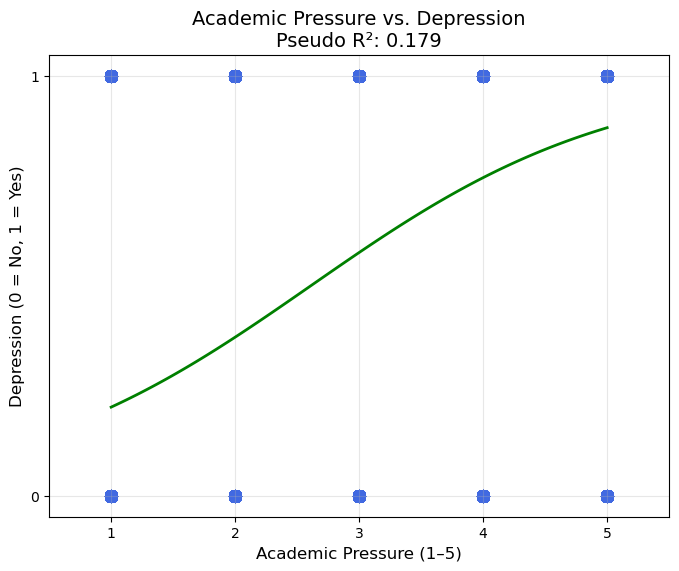

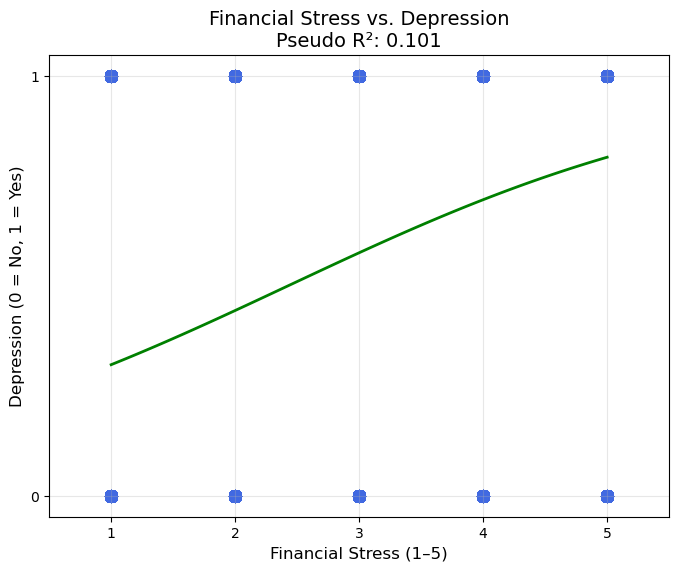

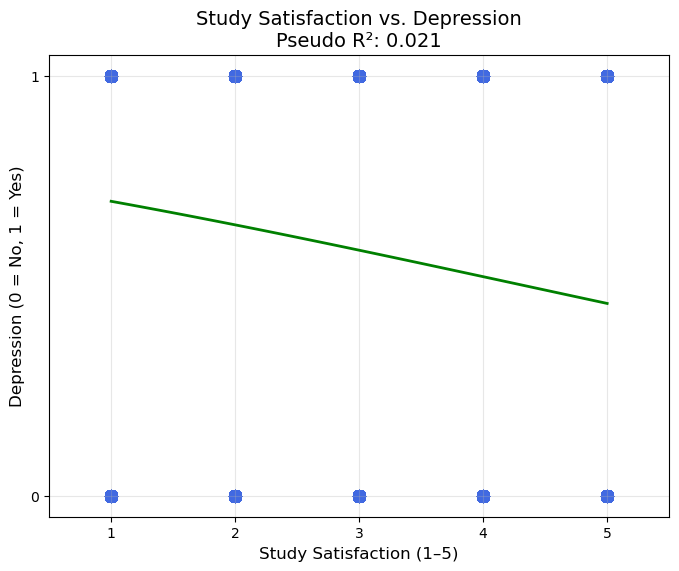

In [68]:

def plot_logistic_regression(df_clean, predictor, result, x_label, title):
    """
    Plots a logistic regression graph using Seaborn’s regplot.
    
    Parameters:
      df_clean (pd.DataFrame): The cleaned data.
      predictor (str): The predictor column name.
      result: The fitted logistic regression result object.
      x_label (str): Label for the x-axis.
      title (str): Title for the plot.
      
    The function annotates the plot with the pseudo R² (McFadden's R²).
    """
    pseudo_r2 = result.prsquared  # McFadden's pseudo R²
    plt.figure(figsize=(8, 6))
    
    # Plot the logistic regression using Seaborn.
    sns.regplot(
        x=predictor,
        y='Depression',
        data=df_clean,
        logistic=True,
        ci=None,  # Disable confidence intervals for clarity.
        scatter_kws={'alpha': 0.7, 'color': 'royalblue', 's': 70},
        line_kws={'color': 'green', 'linewidth': 2}
    )
    
    plt.xlabel(f"{x_label} (1–5)", fontsize=12)
    plt.ylabel("Depression (0 = No, 1 = Yes)", fontsize=12)
    plt.title(f"{title}\nPseudo R²: {pseudo_r2:.3f}", fontsize=14)
    
    # Set x-axis limits and ticks.
    plt.xlim(0.5, 5.5)
    plt.xticks([1, 2, 3, 4, 5])
    # Set y-axis ticks for binary outcome.
    plt.yticks([0, 1])
    
    plt.grid(True, alpha=0.3)
    plt.show()

# df = pd.read_csv
df = pd.read_csv("student_depression_dataset.csv")

# Plot for Academic Pressure vs. Depression.
df_ap = clean_data(df, 'Academic Pressure')
result_ap = logistic_regression(df_ap, 'Academic Pressure')
plot_logistic_regression(df_ap, 'Academic Pressure', result_ap,
                         x_label="Academic Pressure",
                         title="Academic Pressure vs. Depression")

# Plot for Financial Stress vs. Depression.
df_fs = clean_data(df, 'Financial Stress')
result_fs = logistic_regression(df_fs, 'Financial Stress')
plot_logistic_regression(df_fs, 'Financial Stress', result_fs,
                         x_label="Financial Stress",
                         title="Financial Stress vs. Depression")

# Plot for Study Satisfaction vs. Depression.
df_ss = clean_data(df, 'Study Satisfaction')
result_ss = logistic_regression(df_ss, 'Study Satisfaction')
plot_logistic_regression(df_ss, 'Study Satisfaction', result_ss,
                         x_label="Study Satisfaction",
                         title="Study Satisfaction vs. Depression")



Given that our outcome of interest, Depression, is a binary variable (depressed vs. not depressed), we employed logistic regression to model the relationship between the predictors and the probability of depression. Logistic regression is appropriate for binary classification problems because it estimates the log-odds of the positive class (depression=1) as a linear combination of the predictors, and produces an S-shaped curve (logistic function) that outputs probabilities between 0 and 1. This allows us to interpret how changes in each factor affect the likelihood of a student being depressed. In contrast to a linear regression, logistic regression handles the dichotomous nature of the target without violating assumptions or predicting unrealistic values outside。

These logistic regression scatter plots allow visualization of how the probability of depression changes with each predictor. We also calculated the pseudo R² (McFadden’s R²) for each model as a measure of goodness-of-fit. The pseudo R² is derived from the model’s likelihood and indicates the proportion of the log-likelihood explained by the predictor relative to a null model with no predictors. While not identical to the R² in linear regression, a higher pseudo R² still suggests a stronger association between the predictor and the outcome.

- Logistic regression of Depression vs Academic Pressure. This plot shows how the likelihood of depression increases with rising academic pressure. Each blue dot represents an individual student (jittered for visibility along the 0–1 y-axis). The green curve is the fitted logistic regression model, illustrating the steep upward trend: as Academic Pressure moves from low to high, the predicted probability of depression climbs correspondingly. The annotated pseudo R² ≈ 0.18 suggests that academic pressure alone explains about 18% of the variance in depression outcomes in this dataset, and notably the strongest among the single-factor models considered in this study.

- Logistic regression of Depression vs Financial Stress. Higher financial stress is also associated with a higher probability of being depressed. We observe a positive correlation: students reporting minimal financial stress (Stress = 1) have a lower depression rate, whereas those under extreme financial stress (Stress = 5) have a much higher depression rate. The logistic fit captures this increasing trend, though it is somewhat more gradual compared to academic pressure’s effect. The R² ≈ 0.10 for this model indicates a weaker fit than the academic pressure model – financial stress still has a meaningful association with student depression, but it accounts for about 10% of the variance in the outcome, suggesting other factors also play substantial roles.

- Logistic regression of Depression vs Study Satisfaction. In contrast to the pressure and stress variables, Study Satisfaction shows a negative relationship with depression. Students who are very dissatisfied with their studies (Satisfaction = 1) have the highest observed depression prevalence, whereas those who are very satisfied (Satisfaction = 5) exhibit a lower depression rate. The downward-sloping logistic curve reflects this protective effect: as study satisfaction increases, the predicted probability of depression decreases. However, the R² is only about 0.02, indicating that study satisfaction alone explains roughly 2% of the variation in depression. This is a relatively small effect size, implying that while the trend is in the expected direction (higher satisfaction correlates with lower depression risk), its standalone predictive power is quite limited compared to the stronger stress factors above.


Each predictor—Academic Pressure, Financial Stress, and Study Satisfaction—was processed separately using these functions. The resulting visualizations provided clear, interpretable graphics that depict how an increase in each stress or satisfaction variable affects the probability of a student being depressed. For instance, our Academic Pressure plot shows a steep upward trend, suggesting that as academic pressure increases, the likelihood of depression rises significantly, which is supported by a moderate pseudo R² value.

Overall, by dividing the analysis into distinct functions for data cleaning, model fitting, and visualization, our methodology facilitated a systematic and reproducible exploration of the factors influencing student depression. This approach not only improved code readability and maintenance but also ensured that each analytical step could be independently verified and adjusted as needed for further refinement or the inclusion of additional variables in future work.


# 4. Results, Conclusions, and Future Work

#### Results Summary: 
The logistic regression analysis identified **Academic Pressure** and **Financial Stress** as the factors most strongly associated with student depression in this dataset. Academic pressure had the highest pseudo R² (~0.18) among the single-factor models, suggesting that students overwhelmed by coursework and academic demands are considerably more likely to report depression. Financial stress was the second strongest predictor (pseudo R² ~0.10), indicating that economic strain – such as worrying about tuition, living expenses, or financial security – also correlates with a higher risk of depression, though not as strongly as academic pressure. In practical terms, both high academic pressure and high financial stress correspond to a significantly elevated probability of a student being depressed (as the figures illustrate: the probability roughly triples or more from the lowest to highest levels of these stressors). 


On the other hand, **Study Satisfaction** showed a negative relationship with depression, aligning with the expectation that students who feel content with their studies and academic experience are less likely to be depressed. However, the effect of study satisfaction was relatively small (pseudo R² ~0.02). This implies that although improving study satisfaction (for instance, through engaging teaching, academic support, or aligning coursework with student interests) might help reduce depression risk, it alone does not dramatically change the odds of depression in the way that severe stressors do. In the data, even the most satisfied students still had some non-negligible depression rates, and the least satisfied had high rates, but the gradient between them was not as steep as the gradients for pressure or financial stress. 



#### Conclusions: 
In summary, the analysis supports the conclusion that **academic-related stressors are significant contributors to student depression**. High academic pressure emerged as the most influential factor among those examined, underscoring how critical academic workload and performance pressure is to student mental health. Financial stress is another key contributor – financial hardships or concerns can compound the psychological burden on students, leading to higher depression prevalence. Conversely, having a satisfying study experience can be somewhat protective, although by itself it is not enough to counteract the strong impact of stress and pressure. These findings resonate with existing literature that links academic stress and financial difficulties to mental health problems in students. 

https://pmc.ncbi.nlm.nih.gov/articles/PMC9243415/#:~:text=between%20stress%2C%20depression%2C%20and%20academic,their%20childrens%27%20education%20and%20performance 

They also highlight that while positive experiences (satisfaction, engagement) at school are beneficial, mitigating the intense pressures students face may be even more crucial in addressing depression. It’s important to note that the pseudo R² values obtained are moderate at best, which indicates that **no single factor explains the majority of variance in depression**. Depression is a multi-faceted issue; the factors studied here contribute to it, but there are likely many other influential variables (and complex interactions between them) that determine a student’s mental health outcome. The moderate fit of even the strongest predictor (academic pressure) suggests that interventions solely targeting one aspect of student life might have limited effect – a holistic approach is needed. 



#### Future Work and Recommendations:
There is ample scope to extend and improve this analysis. To more comprehensively understand and predict student depression, future work should consider the following enhancements:

- Incorporate Additional Variables: Include more of the available features (and potentially gather new ones) that might influence depression. For example, social support and relationships, sleep quality and duration, physical health/exercise, and history of mental illness in the family are all factors known to affect mental well-being. The current dataset already contains some relevant fields (e.g. sleep duration, family mental health history, suicidal thoughts) which could be utilized. Including these could improve the explanatory power of the model and provide a fuller picture of a student’s life.

- Multivariate Modeling: Develop a multivariate logistic regression or other multivariable models that consider all significant factors together, rather than one at a time. This would allow analysis of the combined effect of academic pressure, financial stress, study satisfaction, and other predictors in one model, and could reveal interaction effects (for instance, whether the impact of academic pressure on depression is exacerbated by financial stress). Interaction terms and non-linear effects could be tested to see if certain combinations of stressors have an especially large impact on depression risk. A multivariate approach would likely increase the pseudo R², as more variance in the outcome can be accounted for with multiple predictors.

- Advanced Machine Learning Models: To improve predictive accuracy and handle complex patterns, one could apply machine learning algorithms such as decision trees, random forests, gradient boosting machines, or support vector machines to this problem. These models can capture non-linear relationships and interactions automatically and might provide better prediction of which students are at risk of depression. Additionally, techniques like cross-validation should be used to ensure the model generalizes well. While the goal of this project was more to explain associations than to optimize prediction, a future project could focus on building a depression risk prediction tool. Such a tool, trained on a rich set of features (including academic, financial, social, and personal factors), could help educational institutions identify at-risk students and intervene earlier.

Finally, it would be beneficial to gather data from diverse student populations (beyond the primarily single-country sample in this dataset) to improve the robustness and generalizability of findings. By addressing the above points – broadening the factors considered, using multivariate and machine learning approaches, and validating on diverse samples – future research can build on this work to more precisely pinpoint the drivers of student depression and inform more effective prevention and support strategies. Ensuring student mental health remains a priority is essential, as healthier students are better positioned to succeed academically and personally. The insights from data science, combined with proactive policy and counseling efforts, can contribute to alleviating the burden of depression in academic settings, ultimately improving student outcomes and well-being.

https://www.mayoclinichealthsystem.org/hometown-health/speaking-of-health/college-students-and-depression#:~:text=intense%20pressure%20to%20succeed%20while,still%20developing%20necessary%20life%20skills